# Part I: Set Up

### Importing dependencies

In [258]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib as pl

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Collecting the dataset

In [259]:
!kaggle datasets download -d rahmasleam/flowers-dataset --unzip -p ./
url = "https://www.kaggle.com/datasets/rahmasleam/flowers-dataset"

Dataset URL: https://www.kaggle.com/datasets/rahmasleam/flowers-dataset
License(s): apache-2.0
100% 219M/219M [00:01<00:00, 130MB/s]
100% 219M/219M [00:01<00:00, 163MB/s]


In [260]:
tf.keras.utils.get_file('flower_photos.tar', origin=url, extract=True)
data_dir = "/content/flower_photos"

<ipython-input-260-55571ad95dfd>:1: UserWarning: Could not extract archive.
  tf.keras.utils.get_file('flower_photos.tar', origin=url, extract=True)


### Defining image size and shape

In [261]:
batch_size = 32
img_height = 180
img_width = 180
channels = 3
img_size = (img_height, img_width)
img_shape = (img_height, img_width, channels)

### Validation split with resizing and batching

In [262]:
x_train, x_val = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="both",
  seed=42,
  image_size=img_size,
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Using 734 files for validation.


### Peak into the dataset

Class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Number of batches: 92


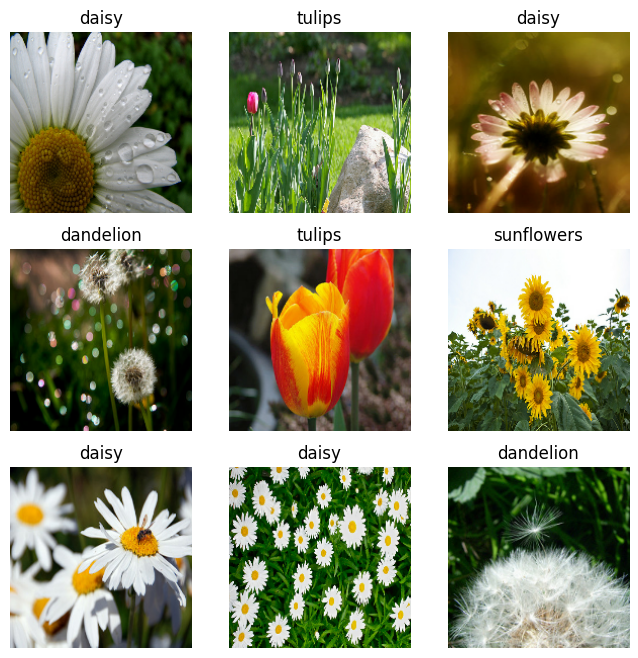

In [263]:
class_names = x_train.class_names
print(f"Class names: {class_names}")

num_batches = len(x_train)
print(f"Number of batches: {num_batches}")

plt.figure(figsize=(8, 8))
for images, labels in x_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

#Part II: Model

### Definition
**Note:** I decided to make rescaling and augmentation layers as parts of my model for neatness. resizing was done with `image_dataset_from_directory()` method earlier in part one.

In [264]:
class ImageClassifier:
  def __init__(self, img_shape, num_classes, epochs):
    self.img_shape = img_shape
    self.num_classes = num_classes
    self.epochs = epochs
    self.model = self.build()

  def build(self):
    augmentation_layer = keras.Sequential([
        layers.RandomFlip("horizontal", input_shape=img_shape),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
      ])
    return Sequential([
        layers.Rescaling(1./255, input_shape=self.img_shape),
        augmentation_layer,
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(self.num_classes)
    ])

  def compile(self):
    return self.model.compile(optimizer='adam',
                              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                              metrics=['accuracy'])

  def fit(self, x_train, x_val, patience=10):
    early_stopping = EarlyStopping(
        patience=patience,
        monitor='val_loss',
        restore_best_weights=True
    )
    history = self.model.fit(
        x_train,
        epochs=self.epochs,
        validation_data=x_val,
        callbacks=[early_stopping]
    )
    return history

  def predict(self, data):
    return self.model.predict(data)

  def summary(self):
    return self.model.summary()

### Initialization

In [265]:
epochs = 10
num_classes = len(class_names)

model = ImageClassifier(img_shape, num_classes, epochs)
model.compile()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Summary

In [266]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_12 (Sequential)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [267]:
history = model.fit(x_train, x_val)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.3208 - loss: 1.5409 - val_accuracy: 0.5531 - val_loss: 1.0906
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.5569 - loss: 1.0758 - val_accuracy: 0.5886 - val_loss: 1.0209
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.6034 - loss: 0.9740 - val_accuracy: 0.6281 - val_loss: 0.9404
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.6514 - loss: 0.8815 - val_accuracy: 0.6253 - val_loss: 0.9456
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.6717 - loss: 0.8321 - val_accuracy: 0.6730 - val_loss: 0.8703
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.7020 - loss: 0.7862 - val_accuracy: 0.6921 - val_loss: 0.8630
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.7128 - loss: 0.7474 - val_accuracy: 0.6894 - val_loss: 0.8194
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7177 - loss: 0.7153 - val_accuracy: 0.6839 - v

# Part III: Visualisation

### Accuracy and loss

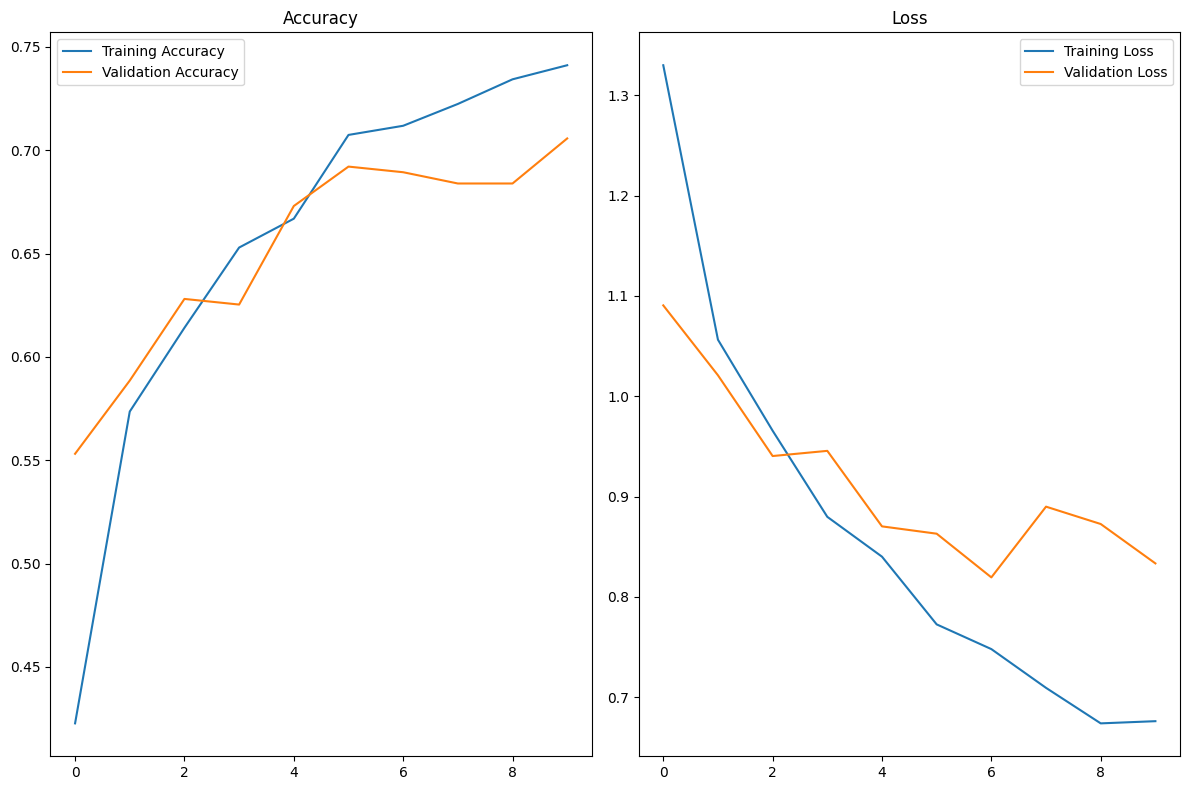

In [268]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Epochs = [int(i) for i in range(epochs)]

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(Epochs, acc, label='Training Accuracy')
plt.plot(Epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, loss, label='Training Loss')
plt.plot(Epochs, val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Confusion matrix and report

In [269]:
labels = x_val.class_names

In [270]:
predictions = model.predict(data=x_val)
predictions = np.argmax(predictions, axis=1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 401ms/step


In [271]:
actual_labels = []
for _, label in x_val:
  actual_labels.extend(label.numpy())

In [272]:
cm = confusion_matrix(actual_labels, predictions)
cm

array([[ 72,  17,   6,   8,   4],
       [ 15, 146,   4,  21,   5],
       [  6,  10,  59,   7,  37],
       [  1,   9,   5, 110,  10],
       [  8,  19,  20,  16, 119]])

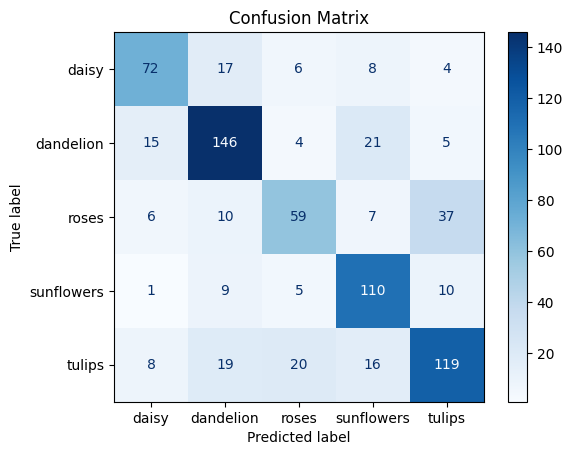

In [273]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [274]:
print(classification_report(actual_labels, predictions, target_names=labels))

              precision    recall  f1-score   support

       daisy       0.71      0.67      0.69       107
   dandelion       0.73      0.76      0.74       191
       roses       0.63      0.50      0.55       119
  sunflowers       0.68      0.81      0.74       135
      tulips       0.68      0.65      0.67       182

    accuracy                           0.69       734
   macro avg       0.68      0.68      0.68       734
weighted avg       0.69      0.69      0.69       734



### Predictions

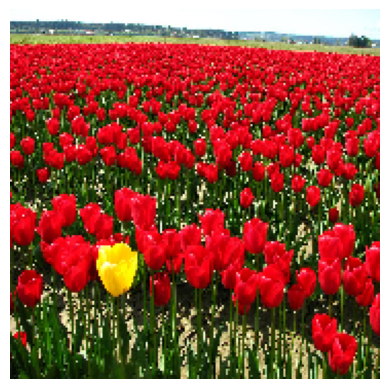

In [275]:
test_image = load_img("/content/tulips.jpg", target_size=img_size)
img_array = img_to_array(test_image)

plt.imshow(img_array.astype("uint8"))
plt.axis('off')
plt.show()

In [276]:
img_array = tf.expand_dims(img_array, 0)

pred = model.predict(img_array)
score = tf.nn.softmax(pred[0])

print(
    "Predicted class {} with confidence of {:.2f}%."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Predicted class tulips with confidence of 99.52%.
